# Naive Bayes Binary Classification - FTR DRAW

In [612]:
# Importing the library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # visualization library based on matplotlib
from IPython.display import display # Manage multiple output per cell

In [613]:
# Manage UTF-8 issue
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

## Importing Data

In [614]:
# DB Sqlite connection
import sqlite3
db = "/Users/thibaultclement/Project/ligue1-predict/src/notebook/data/db/soccer_predict.sqlite"
conn = sqlite3.connect(db)
cur = conn.cursor()

In [615]:
# Get all prematch
df = pd.read_sql_query("SELECT * FROM pre_matchs ORDER BY INFO_Date ASC;", conn)
df = (df[df.columns.drop(['index'])])
df.shape

(15801, 102)

In [616]:
# Remove all game between June (include) and October (include)
df['INFO_Date'] = pd.to_datetime(df['INFO_Date'])
df['INFO_Date'].dt.month
df = df[(df['INFO_Date'].dt.month < 6) | (df['INFO_Date'].dt.month > 10)]
df.shape

(11276, 102)

In [617]:
# Remove league I don't want
#df = df[(df['INFO_Div'] != 'E1') & (df['INFO_Div'] != 'E2') & (df['INFO_Div'] != 'SC0')]
#df = df[(df['INFO_Div'] == 'D1')]
df = df[(df['INFO_Div'] == 'I1')]
df.shape

(1400, 102)

In [618]:
# Check the average odd
df.INFO_PSD.mean()

4.015147164393399

In [619]:
# Removing column where bet for Draw is too high or too low
df = df.drop(df[df.INFO_PSD < 2].index)
df = df.drop(df[df.INFO_PSD > 6].index)
df.shape

(1306, 102)

In [620]:
df.INFO_PSD.mean()

3.7828329484218703

In [621]:
# Create a INFO_WIN column containing the gain. If bet success it's equal to odd -1, else -1 (lose you bet)
df['INFO_WIN'] = df['INFO_PSD']-1
df.loc[df.INFO_FTR != 'D', 'INFO_WIN'] = -1

In [622]:
# Statistic for Draw odd after removing low and high odds
display(plt.show(), 100. * df.INFO_FTR.value_counts() / len(df.INFO_FTR))

None

H    41.883614
A    30.934150
D    27.182236
Name: INFO_FTR, dtype: float64

In [623]:
# How much did you win per match if bet on all
df.INFO_WIN.mean()

-0.00025326170376055673

In [624]:
# Keep season 2016/2017 for further test and don't use it for traning
import datetime
date_start_current_season = datetime.date(2016, 8, 1)
df_current_season = df[(df['INFO_Date'] > date_start_current_season)]
df = df[(df['INFO_Date'] < date_start_current_season)]

In [625]:
df_current_season.shape

(238, 103)

In [626]:
# Prepare the dataset
# all feature except info
all_features = ["A_FIVE_AC","A_FIVE_AF","A_FIVE_AR","A_FIVE_AS","A_FIVE_AST","A_FIVE_AY","A_FIVE_FTAG","A_FIVE_FTHG","A_FIVE_FTR_A","A_FIVE_FTR_D","A_FIVE_FTR_H","A_FIVE_HC","A_FIVE_HF","A_FIVE_HR","A_FIVE_HS","A_FIVE_HST","A_FIVE_HTAG","A_FIVE_HTHG","A_FIVE_HTR_A","A_FIVE_HTR_D","A_FIVE_HTR_H","A_FIVE_HY","H_FIVE_AC","H_FIVE_AF","H_FIVE_AR","H_FIVE_AS","H_FIVE_AST","H_FIVE_AY","H_FIVE_FTAG","H_FIVE_FTHG","H_FIVE_FTR_A","H_FIVE_FTR_D","H_FIVE_FTR_H","H_FIVE_HC","H_FIVE_HF","H_FIVE_HR","H_FIVE_HS","H_FIVE_HST","H_FIVE_HTAG","H_FIVE_HTHG","H_FIVE_HTR_A","H_FIVE_HTR_D","H_FIVE_HTR_H","H_FIVE_HY","A_THREE_AC","A_THREE_AF","A_THREE_AR","A_THREE_AS","A_THREE_AST","A_THREE_AY","A_THREE_FTAG","A_THREE_FTHG","A_THREE_FTR_A","A_THREE_FTR_D","A_THREE_FTR_H","A_THREE_HC","A_THREE_HF","A_THREE_HR","A_THREE_HS","A_THREE_HST","A_THREE_HTAG","A_THREE_HTHG","A_THREE_HTR_A","A_THREE_HTR_D","A_THREE_HTR_H","A_THREE_HY","H_THREE_AC","H_THREE_AF","H_THREE_AR","H_THREE_AS","H_THREE_AST","H_THREE_AY","H_THREE_FTAG","H_THREE_FTHG","H_THREE_FTR_A","H_THREE_FTR_D","H_THREE_FTR_H","H_THREE_HC","H_THREE_HF","H_THREE_HR","H_THREE_HS","H_THREE_HST","H_THREE_HTAG","H_THREE_HTHG","H_THREE_HTR_A","H_THREE_HTR_D","H_THREE_HTR_H","H_THREE_HY","INFO_Div"] 
three_matches_features = ["A_THREE_AC","A_THREE_AF","A_THREE_AR","A_THREE_AS","A_THREE_AST","A_THREE_AY","A_THREE_FTAG","A_THREE_FTHG","A_THREE_FTR_A","A_THREE_FTR_D","A_THREE_FTR_H","A_THREE_HC","A_THREE_HF","A_THREE_HR","A_THREE_HS","A_THREE_HST","A_THREE_HTAG","A_THREE_HTHG","A_THREE_HTR_A","A_THREE_HTR_D","A_THREE_HTR_H","A_THREE_HY","H_THREE_AC","H_THREE_AF","H_THREE_AR","H_THREE_AS","H_THREE_AST","H_THREE_AY","H_THREE_FTAG","H_THREE_FTHG","H_THREE_FTR_A","H_THREE_FTR_D","H_THREE_FTR_H","H_THREE_HC","H_THREE_HF","H_THREE_HR","H_THREE_HS","H_THREE_HST","H_THREE_HTAG","H_THREE_HTHG","H_THREE_HTR_A","H_THREE_HTR_D","H_THREE_HTR_H","H_THREE_HY","INFO_Div"]
five_matches_features = ["A_FIVE_AC","A_FIVE_AF","A_FIVE_AR","A_FIVE_AS","A_FIVE_AST","A_FIVE_AY","A_FIVE_FTAG","A_FIVE_FTHG","A_FIVE_FTR_A","A_FIVE_FTR_D","A_FIVE_FTR_H","A_FIVE_HC","A_FIVE_HF","A_FIVE_HR","A_FIVE_HS","A_FIVE_HST","A_FIVE_HTAG","A_FIVE_HTHG","A_FIVE_HTR_A","A_FIVE_HTR_D","A_FIVE_HTR_H","A_FIVE_HY","H_FIVE_AC","H_FIVE_AF","H_FIVE_AR","H_FIVE_AS","H_FIVE_AST","H_FIVE_AY","H_FIVE_FTAG","H_FIVE_FTHG","H_FIVE_FTR_A","H_FIVE_FTR_D","H_FIVE_FTR_H","H_FIVE_HC","H_FIVE_HF","H_FIVE_HR","H_FIVE_HS","H_FIVE_HST","H_FIVE_HTAG","H_FIVE_HTHG","H_FIVE_HTR_A","H_FIVE_HTR_D","H_FIVE_HTR_H","H_FIVE_HY","INFO_Div"]
all_features_no_div = ["A_FIVE_AC","A_FIVE_AF","A_FIVE_AR","A_FIVE_AS","A_FIVE_AST","A_FIVE_AY","A_FIVE_FTAG","A_FIVE_FTHG","A_FIVE_FTR_A","A_FIVE_FTR_D","A_FIVE_FTR_H","A_FIVE_HC","A_FIVE_HF","A_FIVE_HR","A_FIVE_HS","A_FIVE_HST","A_FIVE_HTAG","A_FIVE_HTHG","A_FIVE_HTR_A","A_FIVE_HTR_D","A_FIVE_HTR_H","A_FIVE_HY","H_FIVE_AC","H_FIVE_AF","H_FIVE_AR","H_FIVE_AS","H_FIVE_AST","H_FIVE_AY","H_FIVE_FTAG","H_FIVE_FTHG","H_FIVE_FTR_A","H_FIVE_FTR_D","H_FIVE_FTR_H","H_FIVE_HC","H_FIVE_HF","H_FIVE_HR","H_FIVE_HS","H_FIVE_HST","H_FIVE_HTAG","H_FIVE_HTHG","H_FIVE_HTR_A","H_FIVE_HTR_D","H_FIVE_HTR_H","H_FIVE_HY","A_THREE_AC","A_THREE_AF","A_THREE_AR","A_THREE_AS","A_THREE_AST","A_THREE_AY","A_THREE_FTAG","A_THREE_FTHG","A_THREE_FTR_A","A_THREE_FTR_D","A_THREE_FTR_H","A_THREE_HC","A_THREE_HF","A_THREE_HR","A_THREE_HS","A_THREE_HST","A_THREE_HTAG","A_THREE_HTHG","A_THREE_HTR_A","A_THREE_HTR_D","A_THREE_HTR_H","A_THREE_HY","H_THREE_AC","H_THREE_AF","H_THREE_AR","H_THREE_AS","H_THREE_AST","H_THREE_AY","H_THREE_FTAG","H_THREE_FTHG","H_THREE_FTR_A","H_THREE_FTR_D","H_THREE_FTR_H","H_THREE_HC","H_THREE_HF","H_THREE_HR","H_THREE_HS","H_THREE_HST","H_THREE_HTAG","H_THREE_HTHG","H_THREE_HTR_A","H_THREE_HTR_D","H_THREE_HTR_H","H_THREE_HY"] 
three_matches_features_no_div = ["A_THREE_AC","A_THREE_AF","A_THREE_AR","A_THREE_AS","A_THREE_AST","A_THREE_AY","A_THREE_FTAG","A_THREE_FTHG","A_THREE_FTR_A","A_THREE_FTR_D","A_THREE_FTR_H","A_THREE_HC","A_THREE_HF","A_THREE_HR","A_THREE_HS","A_THREE_HST","A_THREE_HTAG","A_THREE_HTHG","A_THREE_HTR_A","A_THREE_HTR_D","A_THREE_HTR_H","A_THREE_HY","H_THREE_AC","H_THREE_AF","H_THREE_AR","H_THREE_AS","H_THREE_AST","H_THREE_AY","H_THREE_FTAG","H_THREE_FTHG","H_THREE_FTR_A","H_THREE_FTR_D","H_THREE_FTR_H","H_THREE_HC","H_THREE_HF","H_THREE_HR","H_THREE_HS","H_THREE_HST","H_THREE_HTAG","H_THREE_HTHG","H_THREE_HTR_A","H_THREE_HTR_D","H_THREE_HTR_H","H_THREE_HY"]
five_matches_features_no_div = ["A_FIVE_AC","A_FIVE_AF","A_FIVE_AR","A_FIVE_AS","A_FIVE_AST","A_FIVE_AY","A_FIVE_FTAG","A_FIVE_FTHG","A_FIVE_FTR_A","A_FIVE_FTR_D","A_FIVE_FTR_H","A_FIVE_HC","A_FIVE_HF","A_FIVE_HR","A_FIVE_HS","A_FIVE_HST","A_FIVE_HTAG","A_FIVE_HTHG","A_FIVE_HTR_A","A_FIVE_HTR_D","A_FIVE_HTR_H","A_FIVE_HY","H_FIVE_AC","H_FIVE_AF","H_FIVE_AR","H_FIVE_AS","H_FIVE_AST","H_FIVE_AY","H_FIVE_FTAG","H_FIVE_FTHG","H_FIVE_FTR_A","H_FIVE_FTR_D","H_FIVE_FTR_H","H_FIVE_HC","H_FIVE_HF","H_FIVE_HR","H_FIVE_HS","H_FIVE_HST","H_FIVE_HTAG","H_FIVE_HTHG","H_FIVE_HTR_A","H_FIVE_HTR_D","H_FIVE_HTR_H","H_FIVE_HY"]
features_list = all_features_no_div
X = pd.get_dummies(df[features_list])
y = pd.get_dummies(df)['INFO_FTR_D'].astype('bool_')
X_current_season = pd.get_dummies(df_current_season[features_list])
y_current_season = pd.get_dummies(df_current_season)['INFO_FTR_D'].astype('bool_')

## Preprocessing Data

In [627]:
# Standardize features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler().fit(X)
X = sc_X.transform(X)
X_current_season = sc_X.transform(X_current_season)

In [628]:
# Impute of missing values (NaN) with the mean
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X)
X = imp.transform(X)
X_current_season = imp.transform(X_current_season)

In [629]:
# Split the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [630]:
# Import Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
classifier = GaussianNB()

## Tuning Hyper-parameters

In [631]:
# Applying Grid Search to find the best hyper-parameters for our Model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.classification import log_loss
from sklearn.metrics import make_scorer

parameters = [{}]
grid_search = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='f1',
                          cv=8,
                          n_jobs=-1)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_score

0.19990926950959559

In [632]:
# Extract best hyper-parameter calculated with the GridSearchCV
best_params = grid_search.best_params_
best_params

{}

## Evaluating Model

In [633]:
# Train a new classifier using the best parameters found by the grid search
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [634]:
# Predict target values
y_pred = clf.predict(X_test)

In [635]:
# Predict probabilities
y_probs = clf.predict_proba(X_test)

In [636]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.29166666666666669, 0.2413793103448276, 0.26415094339622647, None)

In [637]:
# Compute the confusion Matrix
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,183,51,234
True,66,21,87
All,249,72,321


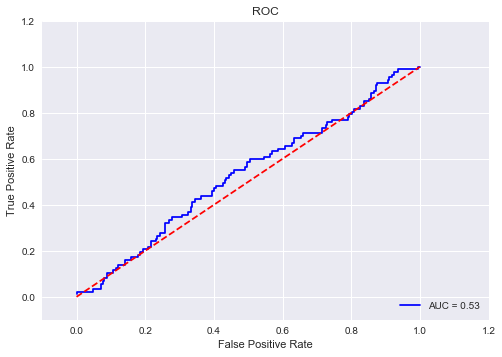

In [638]:
# Plot a ROC curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.ravel(), y_probs[:, 1].ravel())
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

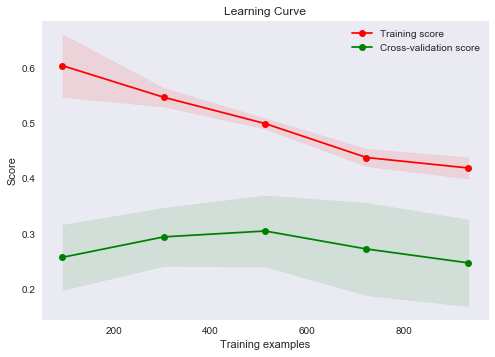

In [639]:
# Plot a leqrning curve
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(clf, 'Learning Curve', X, y, cv=8, n_jobs=-1).show()
plt.show()

# ALL DATASET TEST

In [640]:
# Apply on all the dataset
X_pred = clf.predict(X)
df['pred'] = X_pred
df_bet_draw = df.drop(df[df.pred == 0].index)

In [641]:
# How many Draw bet I did on Draw on all dataset
df_bet_draw.shape

(264, 104)

In [642]:
# What will be the real result of what I bet Draw on all dataset
display(plt.show(), 100. * df_bet_draw.INFO_FTR.value_counts() / len(df_bet_draw.INFO_FTR))

None

D    40.909091
H    35.984848
A    23.106061
Name: INFO_FTR, dtype: float64

In [643]:
# Score for all dataset
precision_recall_fscore_support(y, X_pred, average='binary') 

(0.40909090909090912, 0.35880398671096347, 0.38230088495575226, None)

In [644]:
# Making the confusion Matrix
df_confusion = pd.crosstab(y, X_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,611,156,767
True,193,108,301
All,804,264,1068


In [645]:
df_bet_draw.INFO_WIN.mean()

0.5512121212121214

# SEASON 2016/2017 TEST

In [646]:
# Apply on current season that is not use for train and test set
X_pred_current_season = clf.predict(X_current_season)
df_current_season['pred'] = X_pred_current_season
df_bet_draw_current_season = df_current_season.drop(df_current_season[df_current_season.pred == 0].index)

In [647]:
# How many Draw bet I did on Draw
df_bet_draw_current_season.shape

(28, 104)

In [648]:
X_pred_current_season.shape

(238,)

In [649]:
# What will be the real result of what I bet Draw
display(plt.show(), 100. * df_bet_draw_current_season.INFO_FTR.value_counts() / len(df_bet_draw_current_season.INFO_FTR))

None

A    53.571429
H    32.142857
D    14.285714
Name: INFO_FTR, dtype: float64

In [650]:
# Score for this current season
precision_recall_fscore_support(y_current_season, X_pred_current_season, average='binary') 

(0.14285714285714285, 0.07407407407407407, 0.097560975609756101, None)

In [651]:
# Making the confusion Matrix
df_confusion = pd.crosstab(y_current_season, X_pred_current_season, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,False,True,All
Actual,,,
False,160,24,184
True,50,4,54
All,210,28,238


In [652]:
df_bet_draw_current_season.INFO_WIN.mean()

-0.4328571428571429